### MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORT

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [ ]:
os.system("pip install transformers")
os.system("pip install sentencepiece")
pass

In [ ]:
from transformers import ElectraTokenizer, ElectraModel

### CONSTANTS

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/SNAMA"

DATA_PATH = os.path.join(PROJECT_DIR, "data")
CHECKPOINTS_PATH = os.path.join(PROJECT_DIR, "checkpoints")
MODELS_PATH = os.path.join(PROJECT_DIR, "models")

PREPROCESSED_DATASET_NAME = "amazon_reviews_preprocessed.pckl"
PREPROCESSED_LABELS_NAME = "amazon_reviews_preprocessed_labels.pckl"

MODEL_HASHES_DATASET_NAME = "amazon_reviews_electra_gen_hashes.pckl"

In [ ]:
RANDOM_STATE = 0xd
TEST_SIZE = 0.3

In [ ]:
ELECTRA_FEATURES = 256
NUM_CLASSES = 0x3

In [ ]:
__LOGICAL_CORES__ = 0x4

In [ ]:
__DEVICE__ = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
__HASHES_FOUND__ = os.path.exists(os.path.join(DATA_PATH, MODEL_HASHES_DATASET_NAME))

### IO

In [ ]:
def dump_object(data, file, directory):
    with open(os.path.join(directory, file), 'wb') as file:
        pickle.dump(data, file)


def load_object(file, directory):
    with open(os.path.join(directory, file), 'rb') as file:
        data = pickle.load(file)
        return data


def exists_object(file, directory):
    return os.path.isfile(os.path.join(directory, file))


def dump_model(data, file, directory=MODELS_PATH):
    dump_object(data, file, directory)


def load_model(file, directory=MODELS_PATH):
    return load_object(file, directory)


def exists_model(file, directory=MODELS_PATH):
    return exists_object(file, directory)


def dump_checkpoint(data, file, directory=CHECKPOINTS_PATH):
    dump_object(data, file, directory)


def load_checkpoint(file, directory=CHECKPOINTS_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=CHECKPOINTS_PATH):
    return exists_object(file, directory)


def load_dataset_from_csv(file, directory=DATA_PATH):
    dataframe_ = pd.read_csv(os.path.join(directory, file))
    return dataframe_.Text.values, dataframe_.Score.values


def dump_dataset(data, file, directory=DATA_PATH):
    dump_object(data, file, directory)


def load_dataset(file, directory=DATA_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=DATA_PATH):
    return exists_object(file, directory)

### PREPROCESSED DATA LOADING

In [ ]:
if not __HASHES_FOUND__:
    dataset = load_dataset(PREPROCESSED_DATASET_NAME)
    labels = load_dataset(PREPROCESSED_LABELS_NAME)

### MODEL DEFINITION

In [ ]:
if not __HASHES_FOUND__:
    tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-generator")
    model = ElectraModel.from_pretrained("google/electra-base-generator")

    for param in model.parameters():
        param.requires_grad = False

    model = model.cuda()

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-generator were not used when initializing ElectraModel: ['generator_predictions.dense.weight', 'generator_predictions.LayerNorm.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
if not __HASHES_FOUND__:
    print(model.config, "\n\n")
    print(tokenizer.pretrained_init_configuration)
    print(tokenizer.init_kwargs)

ElectraConfig {
  "_name_or_path": "google/electra-base-generator",
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}
 


{'google/electra-small-generator': {'do_lower_case': True}, 'google/electra-base-generator': {'do_lower_case': True}, 'google/electra-large-generator': {'do_lower_case': True}, 'google/electra-small-discriminator': {'do_l

In [ ]:
class ElectraClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, features=ELECTRA_FEATURES):
        super(ElectraClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=features, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, data):
        return self.classifier(data)

In [ ]:
classifier = ElectraClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

### COMPUTING DATASET HASHES

In [ ]:
if not __HASHES_FOUND__:
    hashes = []
    progress = '0'

    with torch.no_grad():
        for i in range(dataset.shape[0x0]):
            back = '\b' * len(progress)
            progress = str(i + 0x1)
            print(f"{back}{progress}", end="")
            data = tokenizer(dataset[i], 
                             max_length=512,
                             truncation=True, 
                             return_tensors='pt').to(__DEVICE__)
            output = torch.mean(model(**data).last_hidden_state.cpu(), 0x1)
            hashes.append(output)
            del data
            torch.cuda.empty_cache()
    
    hashes_dataset = torch.stack(hashes).squeeze()
 
    dump_dataset(hashes_dataset, MODEL_HASHES_DATASET_NAME)

123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203

### HASHES LOADING

In [ ]:
class TextDataset(Dataset):

    def __init__(self, dataset_, labels_):
        if len(dataset_) != len(labels_):
            raise Exception("Mismatching Lens")

        self.dataset = dataset_
        self.labels = labels_
 

    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, index):
        return (self.dataset[index], self.labels[index])

In [ ]:
hashes_dataset = load_dataset(MODEL_HASHES_DATASET_NAME)
labels = load_dataset(PREPROCESSED_LABELS_NAME)

In [ ]:
training_set, test_set, training_labels, test_labels = train_test_split(hashes_dataset,
                                                                        labels,
                                                                        test_size=TEST_SIZE,
                                                                        random_state=RANDOM_STATE)

In [ ]:
test_labels = torch.tensor(test_labels)

In [ ]:
training_dataset = TextDataset(training_set, training_labels)

In [ ]:
training_loader = DataLoader(dataset=training_dataset,
                             batch_size=0x40,
                             shuffle=True)

### OPTIMIZER & LOSS

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()

In [ ]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING

In [ ]:
def train(model, criterion, optimizer, loader, epochs, device=__DEVICE__):
    total_steps = len(loader)
    loss = 0.0
    min_loss = 0xffffffff
    
    best_weighs = None

    info = ""
    for epoch in range(1, epochs + 1):
        print("Epoch [{}/{}], Loss: {:1.4f}".format(epoch, epochs, loss))

        for batch_idx, (batch_data, batch_labels) in enumerate(loader):  
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            output = model(batch_data)

            loss = criterion(output, batch_labels)

            loss.backward()
            
            optimizer.step()
            if (batch_idx ) % 10 == 0:
                blanks = "\b" * (len(info))
                info = '\tStep [{}/{}], Loss: {:.4f}'.format(batch_idx, total_steps, loss.item())
                print("{}{}".format(blanks, info), end="")    
        
        if loss < min_loss:
            min_loss = loss
            best_weighs = model.state_dict()

        info = ""
        print("")

    return best_weighs

In [ ]:
best_params_50e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.0866	Step [10/2095], Loss: 0.9881	Step [20/2095], Loss: 0.9971	Step [30/2095], Loss: 0.9506	Step [40/2095], Loss: 0.9665	Step [50/2095], Loss: 0.9720	Step [60/2095], Loss: 0.8513	Step [70/2095], Loss: 0.9467	Step [80/2095], Loss: 0.9265	Step [90/2095], Loss: 0.9887	Step [100/2095], Loss: 0.9558	Step [110/2095], Loss: 0.9073	Step [120/2095], Loss: 1.0761	Step [130/2095], Loss: 1.1286	Step [140/2095], Loss: 0.8388	Step [150/2095], Loss: 0.8449	Step [160/2095], Loss: 0.8544

In [ ]:
best_params_100e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.5805	Step [10/2095], Loss: 0.5319	Step [20/2095], Loss: 0.6514	Step [30/2095], Loss: 0.6346	Step [40/2095], Loss: 0.7175	Step [50/2095], Loss: 0.7111	Step [60/2095], Loss: 0.6804	Step [70/2095], Loss: 0.6478	Step [80/2095], Loss: 0.6632	Step [90/2095], Loss: 0.7898	Step [100/2095], Loss: 0.7641	Step [110/2095], Loss: 0.7146	Step [120/2095], Loss: 0.7813	Step [130/2095], Loss: 0.7039	Step [140/2095], Loss: 0.6180	Step [150/2095], Loss: 0.6649	Step [160/2095], Loss: 0.5858

In [30]:
best_params_150e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.7015	Step [10/2095], Loss: 0.5775	Step [20/2095], Loss: 0.7424	Step [30/2095], Loss: 0.5890	Step [40/2095], Loss: 0.6655	Step [50/2095], Loss: 0.6206	Step [60/2095], Loss: 0.6674	Step [70/2095], Loss: 0.6742	Step [80/2095], Loss: 0.7612	Step [90/2095], Loss: 0.6864	Step [100/2095], Loss: 0.5232	Step [110/2095], Loss: 0.6977	Step [120/2095], Loss: 0.5185	Step [130/2095], Loss: 0.4791	Step [140/2095], Loss: 0.4275	Step [150/2095], Loss: 0.6214	Step [160/2095], Loss: 0.4883

In [31]:
checkpoint = classifier.state_dict()

### TEST

In [32]:
def compute_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [33]:
params = [best_params_50e, best_params_100e, best_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i +0x1) * 50, acc))

Checkpoint @50 epochs: 69.0 accuracy
Checkpoint @100 epochs: 69.0 accuracy
Checkpoint @150 epochs: 69.0 accuracy


In [34]:
__DUMP_WEIGHTS__ = True
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "electra_gen_clf_150e_69a.pth"))

### PLOTS

In [35]:
def plot_confusion_matrix(torch_model, data, true_labels, model_name, device=__DEVICE__):
    y_pred_softmax = torch.log_softmax(classifier(data.to(device)), dim=0x1)
    _, y_pred = torch.max(y_pred_softmax, dim=0x1)
    y_pred = y_pred.cpu()
    accuracy = accuracy_score(test_labels, y_pred)
    raw_confusion_matrix = confusion_matrix(test_labels, y_pred)
    display = ConfusionMatrixDisplay(raw_confusion_matrix, display_labels=np.unique(test_labels)).plot(cmap="Blues")
    display.ax_.set_title(f"{model_name} Confusion Matrix (Accuracy: {np.round(accuracy, 0x2)})")
    plt.show()

In [36]:
classifier.load_state_dict(torch.load(os.path.join(MODELS_PATH, "electra_gen_clf_150e_69a.pth")))

<All keys matched successfully>

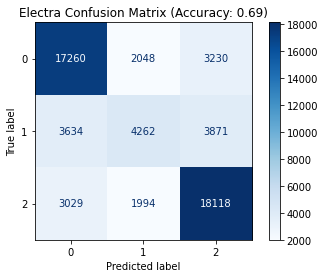

In [37]:
plot_confusion_matrix(classifier, test_set, test_labels, "Electra")

### WEIGHTED LOSS

In [38]:
ins = (1.0 / torch.tensor([np.sum(training_labels == i) for i in range(NUM_CLASSES)])).to(__DEVICE__)

In [39]:
classifier = ElectraClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

In [40]:
cross_entropy_weighted_loss = nn.CrossEntropyLoss(weight=ins)

In [41]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING WEIGHTED

In [42]:
best_weighted_params_50e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.1483	Step [10/2095], Loss: 0.9349	Step [20/2095], Loss: 0.9396	Step [30/2095], Loss: 1.0687	Step [40/2095], Loss: 1.0173	Step [50/2095], Loss: 0.8374	Step [60/2095], Loss: 0.9594	Step [70/2095], Loss: 0.8913	Step [80/2095], Loss: 0.9473	Step [90/2095], Loss: 0.9287	Step [100/2095], Loss: 1.0861	Step [110/2095], Loss: 0.8863	Step [120/2095], Loss: 0.8331	Step [130/2095], Loss: 0.9291	Step [140/2095], Loss: 0.8722	Step [150/2095], Loss: 0.9627	Step [160/2095], Loss: 0.9323

In [43]:
best_weighted_params_100e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.7365	Step [10/2095], Loss: 0.6259	Step [20/2095], Loss: 0.6192	Step [30/2095], Loss: 0.5878	Step [40/2095], Loss: 0.6663	Step [50/2095], Loss: 0.6037	Step [60/2095], Loss: 0.6286	Step [70/2095], Loss: 0.6957	Step [80/2095], Loss: 0.5982	Step [90/2095], Loss: 0.7974	Step [100/2095], Loss: 0.5799	Step [110/2095], Loss: 0.5897	Step [120/2095], Loss: 0.5849	Step [130/2095], Loss: 0.5778	Step [140/2095], Loss: 0.5699	Step [150/2095], Loss: 0.7254	Step [160/2095], Loss: 0.7475

In [44]:
best_weighted_params_150e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.4952	Step [10/2095], Loss: 0.7219	Step [20/2095], Loss: 0.6489	Step [30/2095], Loss: 0.7000	Step [40/2095], Loss: 0.7647	Step [50/2095], Loss: 0.6265	Step [60/2095], Loss: 0.5767	Step [70/2095], Loss: 0.5045	Step [80/2095], Loss: 0.6232	Step [90/2095], Loss: 0.7033	Step [100/2095], Loss: 0.6029	Step [110/2095], Loss: 0.8145	Step [120/2095], Loss: 0.6223	Step [130/2095], Loss: 0.7208	Step [140/2095], Loss: 0.7692	Step [150/2095], Loss: 0.6039	Step [160/2095], Loss: 0.6997

### TEST WEIGHTED

In [45]:
params = [best_weighted_params_50e, best_weighted_params_100e, best_weighted_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i + 0x1) * 50, acc))

Checkpoint @50 epochs: 67.0 accuracy
Checkpoint @100 epochs: 67.0 accuracy
Checkpoint @150 epochs: 67.0 accuracy


In [47]:
__DUMP_WEIGHTS__ = True
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "electra_gen_clf_weighted_150e_67a.pth"))

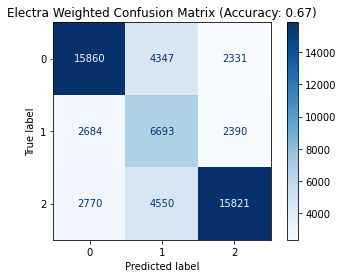

In [46]:
plot_confusion_matrix(classifier, test_set, test_labels, "Electra Weighted")